This notebook is for collecting all data together as a signle df and in the form of [id, audio_data]

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import librosa
from pydub import AudioSegment
import pydub
import matplotlib.pyplot as plt
import random
from typing import List

In [2]:
# integrate all data paths together

parent_directory='../../data/train'

sub_folders=glob.glob(os.path.join(parent_directory,'*'))

files=[]

for folder_path in sub_folders:
    first_file=glob.glob(os.path.join(folder_path,'*.ogg'))
    files.extend(first_file)

In [3]:
print(len(files))
print(files[0])

12
../../data/train/ashpri1/XC116339.ogg


#### because this model is only as initial version, I do not wanna use all data

In [4]:
def read_audio(path:str)->pydub.audio_segment.AudioSegment:
    """
    read ogg file as pydub.audio_segment.AudioSegment for the following steps

    parametere:
        path: *.ogg file path

    return
        audio: the readed audio data
    """
    audio = AudioSegment.from_file(path, format="ogg")

    return audio    

In [5]:
audio_test=read_audio(files[0])

print(audio_test)

In [6]:
# Regarding the data of a single audio, some audio information needs to be paid attention to, such as audio duration, sampling rate, bit rate and number of channels.

def audio_info(audio:pydub.audio_segment.AudioSegment):
    """
    Grab all information of the input audio

    Parameters:
        Audio: the readed audio data

    Return:
        the information of the audio
    """
    # the audio duration time (seconds)
    duration_seconds=len(audio)/1000.0

    # the audio sampling rate
    sr=audio.frame_rate

    # the num of channels
    num_channels=audio.channels

    #bit rate
    bit_rate=audio.sample_width * 8

    return duration_seconds, sr, num_channels, bit_rate



In [7]:
duration_secconds_test,sr_test,num_channels_test,bit_rate_test=audio_info(audio_test)

print(duration_secconds_test)
print(sr_test)
print(num_channels_test)
print(bit_rate_test)


6.452
32000
1
32


In [8]:
# Because the competition requires analysis and classification of every five-second clip, during training, each body of input data should be 5 seconds in length and remain consistent.

def slice_audio_5(audio:pydub.audio_segment.AudioSegment)->List[pydub.audio_segment.AudioSegment]:
    """
    Slice the complete audio into multiple 5 seconds length
    """
    # set up the segment duration
    segment_duration = 5 * 1000

    segments = [audio[i:i + segment_duration] for i in range(0, len(audio), segment_duration)]

    return segments
    


In [9]:
slice_5_test=slice_audio_5(audio_test)

print(slice_5_test)
print(type(slice_5_test))

y0_test=np.array(audio_test.get_array_of_samples())
y1_test=np.array(slice_5_test[0].get_array_of_samples())
y2_test=np.array(slice_5_test[1].get_array_of_samples())

print(len(y0_test))
print(len(y1_test))
print(len(y2_test))
print(y0_test)
print(y1_test)
print(y2_test)

[<pydub.audio_segment.AudioSegment object at 0x12b17d840>, <pydub.audio_segment.AudioSegment object at 0x12b17eec0>]
<class 'list'>
206472
160000
46464
[-68198  19419 -10672 ... -80236  63351 -64358]
[   -68198     19419    -10672 ... -16895870 -23368082   1045371]
[5116708 6058494 3965745 ...   75076 -124341   94026]


In [10]:
for i in slice_5_test:
    y0_test=np.array(i.get_array_of_samples())
    print(len(y0_test))

160000
46464


In [11]:
# Convert audio data into an array

def audio2array(audio_slices:list)->np.array:
    """
    transform audio segments to arrays
    """
    audio_arrays=np.array([np.array(audio_slice.get_array_of_samples()) for audio_slice in audio_slices])

    return audio_arrays

    

In [12]:
audio_arrays_test=audio2array(slice_5_test)

print(audio_arrays_test)

print(type(audio_arrays_test))
print(audio_arrays_test.shape)

print(audio_arrays_test[0])
print(type(audio_arrays_test[0]))

[array([   -68198,     19419,    -10672, ..., -16895870, -23368082,
          1045371], dtype=int32)
 array([5116708, 6058494, 3965745, ...,   75076, -124341,   94026],
       dtype=int32)                                                ]
<class 'numpy.ndarray'>
(2,)
[   -68198     19419    -10672 ... -16895870 -23368082   1045371]
<class 'numpy.ndarray'>


/var/folders/5b/b2jjkdb55_g_qzx3lsl5k59m0000gn/T/ipykernel_27768/620769827.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  audio_arrays=np.array([np.array(audio_slice.get_array_of_samples()) for audio_slice in audio_slices])


In [13]:
# Because I want each slice to be 5 seconds long, I modify the function slice_audio_5 to keep each audio segment aligned to the same length.
# And if the original length of the input audio is less than five seconds, it will be extended to 5 seconds


# def slice_audio_5_align(audio:pydub.audio_segment.AudioSegment)->List[pydub.audio_segment.AudioSegment]:
#     """
#     Slice the complete audio into multiple 5 seconds length,
#     keep all slice have the same length, especially for the last slice

#     Return the list of all audio segments
#     """
#     # set up the segment duration
#     segment_duration = 5 * 1000

#     segments = [audio[i:i + segment_duration] for i in range(0, len(audio), segment_duration)]

#     # Ensure the last segment is exactly 5 seconds long
#     if len(segments[-1]) != segment_duration:
#         last_segment = audio[-segment_duration:]
#         segments[-1] = last_segment

#     return segments


def slice_audio_5_align(audio:pydub.audio_segment.AudioSegment)->List[pydub.audio_segment.AudioSegment]:
    """
    Slice the complete audio into multiple 5 seconds length,
    keep all slice have the same length, especially for the last slice

    Return the list of all audio segments
    """
    # set up the segment duration
    # Set up the segment duration
    segment_duration = 5 * 1000  # 5 seconds in milliseconds

    # Check if the audio is less than 5 seconds
    if len(audio) < segment_duration:
        # Calculate the required padding length
        padding_length = segment_duration - len(audio)
        # Create a silent audio segment for padding
        silence = AudioSegment.silent(duration=padding_length)
        # Pad the audio with silence
        padded_audio = audio + silence
        return [padded_audio]  # Return the padded audio as a single segment

    # If the audio is 5 seconds or longer, proceed as normal
    segments = [audio[i:i + segment_duration] for i in range(0, len(audio), segment_duration)]

    # Ensure the last segment is exactly 5 seconds long
    if len(segments[-1]) != segment_duration:
        last_segment = audio[-segment_duration:]  # Get the last 5 seconds of the audio
        segments[-1] = last_segment  # Replace the last segment with a full 5-second segment

    return segments


In [14]:
slice_5_test=slice_audio_5_align(audio_test)

print(slice_5_test)
print(type(slice_5_test))
print(len(slice_5_test))

y0_test=np.array(audio_test.get_array_of_samples())
y1_test=np.array(slice_5_test[0].get_array_of_samples())
y2_test=np.array(slice_5_test[1].get_array_of_samples())

print(len(y0_test))
print(len(y1_test))
print(len(y2_test))
print(y0_test)
print(y1_test)
print(y2_test)

[<pydub.audio_segment.AudioSegment object at 0x12b17fdc0>, <pydub.audio_segment.AudioSegment object at 0x12b17fc70>]
<class 'list'>
2
206472
160000
160000
[-68198  19419 -10672 ... -80236  63351 -64358]
[   -68198     19419    -10672 ... -16895870 -23368082   1045371]
[-60014236 -33759712 -16823488 ...     75076   -124341     94026]


In [15]:
audio_arrays_test=audio2array(slice_5_test)

print(audio_arrays_test)

print(type(audio_arrays_test))
print(audio_arrays_test.shape)

print(audio_arrays_test[0])
print(type(audio_arrays_test[0]))

[[   -68198     19419    -10672 ... -16895870 -23368082   1045371]
 [-60014236 -33759712 -16823488 ...     75076   -124341     94026]]
<class 'numpy.ndarray'>
(2, 160000)
[   -68198     19419    -10672 ... -16895870 -23368082   1045371]
<class 'numpy.ndarray'>


In [16]:
# Because when reading .ogg data through pydub, the bit rate will be read according to the original bit rate of the data. 
# However, the original bit rate will cause the read data value to be too large, so we need to normalize it according to the bit rate

def audio_bitrate_norm(bit_rate:float,audio_array:np.array):
    """
    because the .ogg file readed through pydub would based off the audio original bit rate,
    we want the value of the audio keep small, 
    so do normalization based off the bit rate.

    Parameters:
        bit_rate: the bit rate of the audio
        audio_array: the data in array form for each single slice
    """
    audio_array_norm = audio_array / float(2**(bit_rate-1))

    return audio_array_norm
    

In [17]:
for array in audio_arrays_test:
    array_norm=audio_bitrate_norm(bit_rate=bit_rate_test,audio_array=array)
    print(array_norm)

[-3.17571685e-05  9.04267654e-06 -4.96953726e-06 ... -7.86775257e-03
 -1.08816111e-02  4.86788806e-04]
[-2.79463064e-02 -1.57205909e-02 -7.83404708e-03 ...  3.49599868e-05
 -5.79007901e-05  4.37842682e-05]


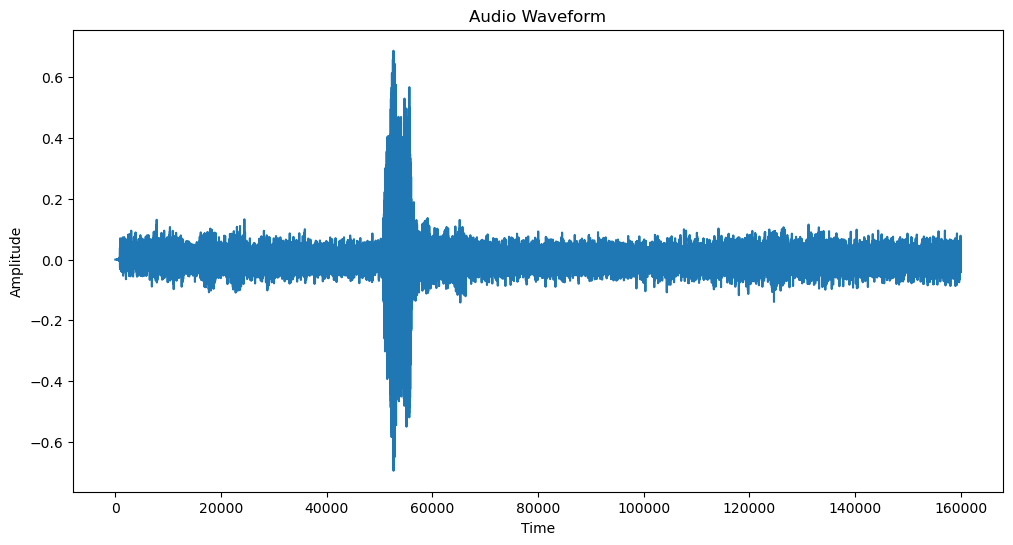

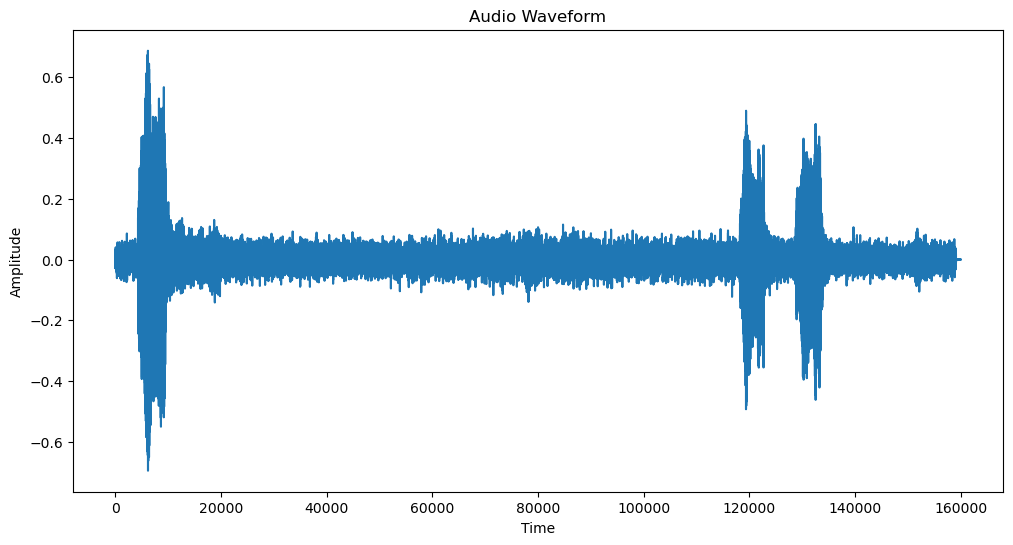

In [18]:
for array in audio_arrays_test:
    array_norm=audio_bitrate_norm(bit_rate=bit_rate_test,audio_array=array)

    plt.figure(figsize=(12, 6))
    plt.plot(array_norm)
    plt.title('Audio Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

In [19]:
# Next, I need to randomly sample segments of each 5-second audio and combine them into a complete audio with a length of 2 seconds.

def audio_random_sampling_2(total_samples:int,audio_segment:pydub.audio_segment.AudioSegment)-> List[pydub.audio_segment.AudioSegment]:
    """
    Randomly extract audio clips and combine them into 2 seconds of audio

    Parameters:
        total_samples: the number of randomly synthesized audio clips
        audio_segment: the single audio segment in form `pydub.audio_segment.AudioSegment`

    Return:
        The list of all random extract audio clips in form `pydub.audio_segment.AudioSegment`

    """
    random_clips=[]
    clip_num=0

    # the goal is to randomly extract a total of 2 seconds of audio
    total_duration_ms = 2*1000

    while clip_num<total_samples:
        # Storing the extracted fragments
        extracted_segments = AudioSegment.silent(duration=0)  # Create a silent clip for subsequent splicing

        # Continue looping when the total length of the extracted segments is less than 2 seconds
        while extracted_segments.duration_seconds < 2:
            # random select a start point
            start_ms = random.randint(0, len(audio_segment) - 1)
            # Calculate the maximum duration that can be extracted
            max_extract_ms = total_duration_ms - int(extracted_segments.duration_seconds * 1000)
            # determine the duration of this draw
            extract_duration_ms = random.randint(1, max_extract_ms)
            # Randomly selected snippets
            extract = audio_segment[start_ms:start_ms+extract_duration_ms]

            extracted_segments += extract

        # The final discontinuous random 2 seconds of audio data
        random_two_seconds = extracted_segments

        random_clips.append(random_two_seconds)

        clip_num+=1

    return random_clips
    

[<pydub.audio_segment.AudioSegment object at 0x12b766d70>, <pydub.audio_segment.AudioSegment object at 0x12b764c70>, <pydub.audio_segment.AudioSegment object at 0x12b766c80>, <pydub.audio_segment.AudioSegment object at 0x12b767340>, <pydub.audio_segment.AudioSegment object at 0x12b766710>]
5
[[  35340716   13443709    9911463 ...   12445045   -8800957  -33916136]
 [ -90776704  -84270616  -81507184 ...   58904284   53794048   52727560]
 [  -8036882   -7627564     660785 ...  -26574120  -66761808 -134176712]
 [  58483464   52569368   63585928 ...  -33555508  -17788800  -18146062]
 [  32101694   50033160   62173628 ...   -2921872  -38350760  -61290236]]
[ 35340716  13443709   9911463 ...  12445045  -8800957 -33916136]
<class 'numpy.ndarray'>


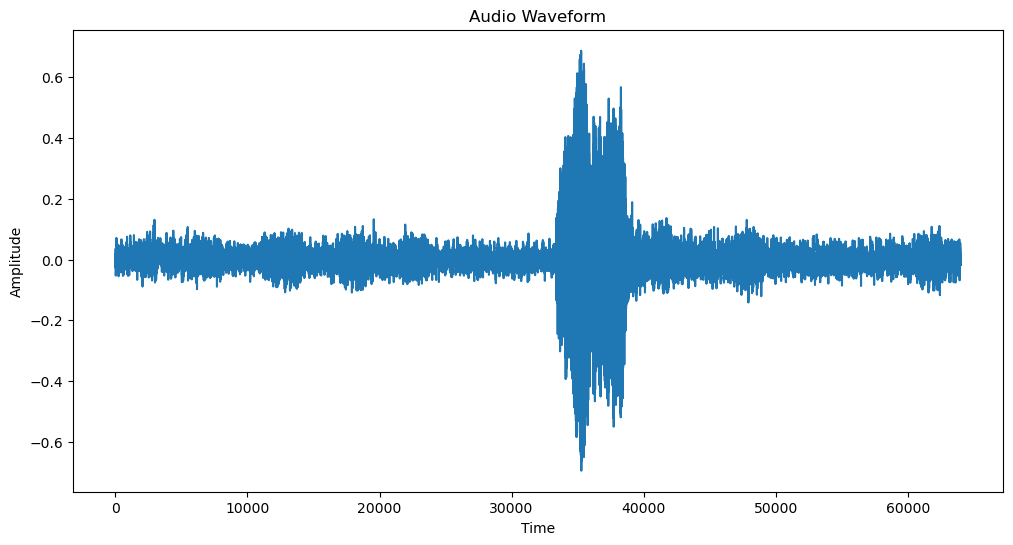

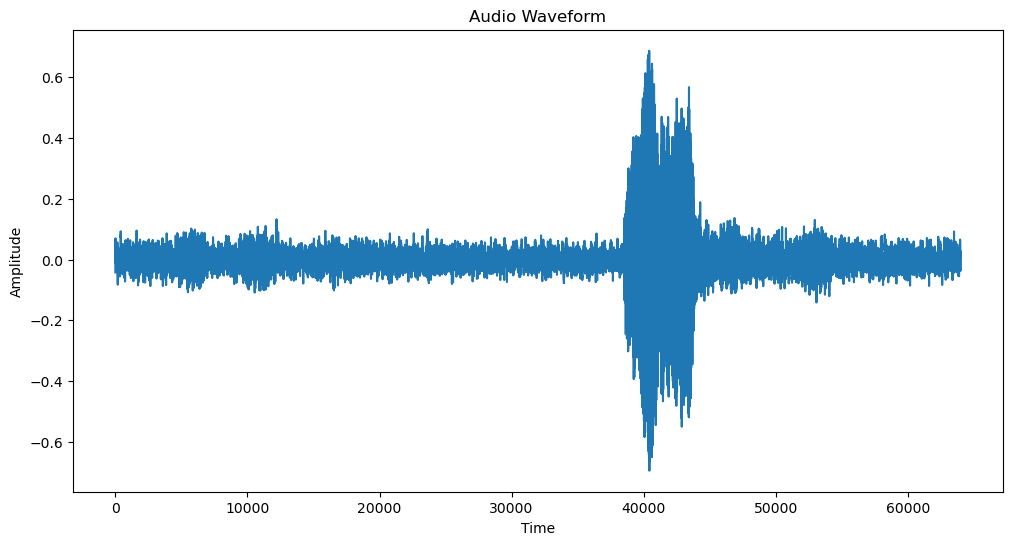

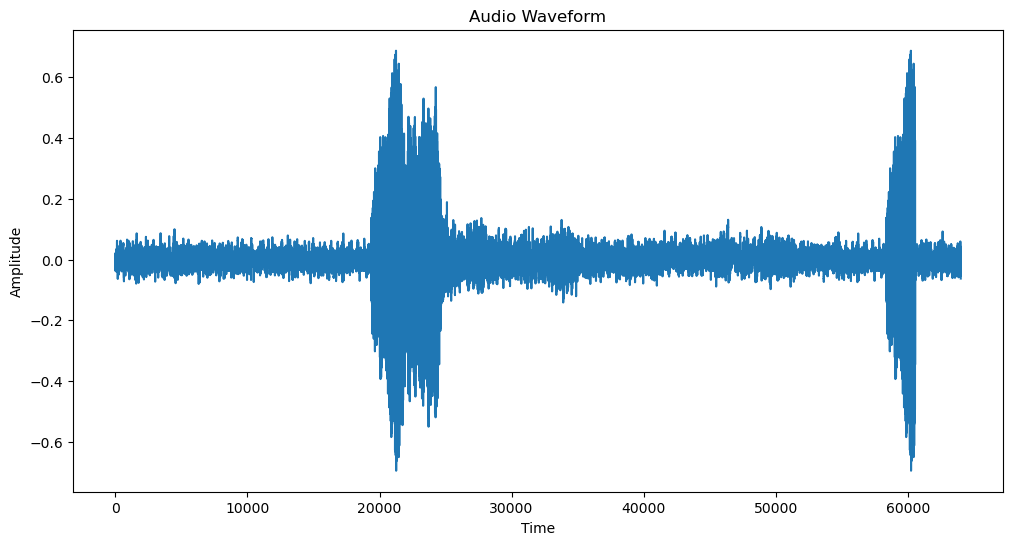

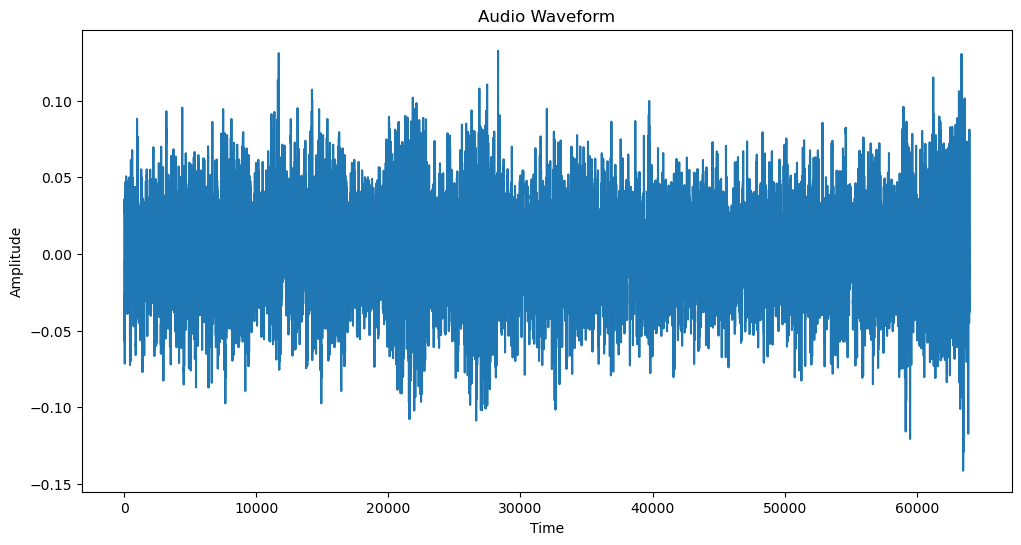

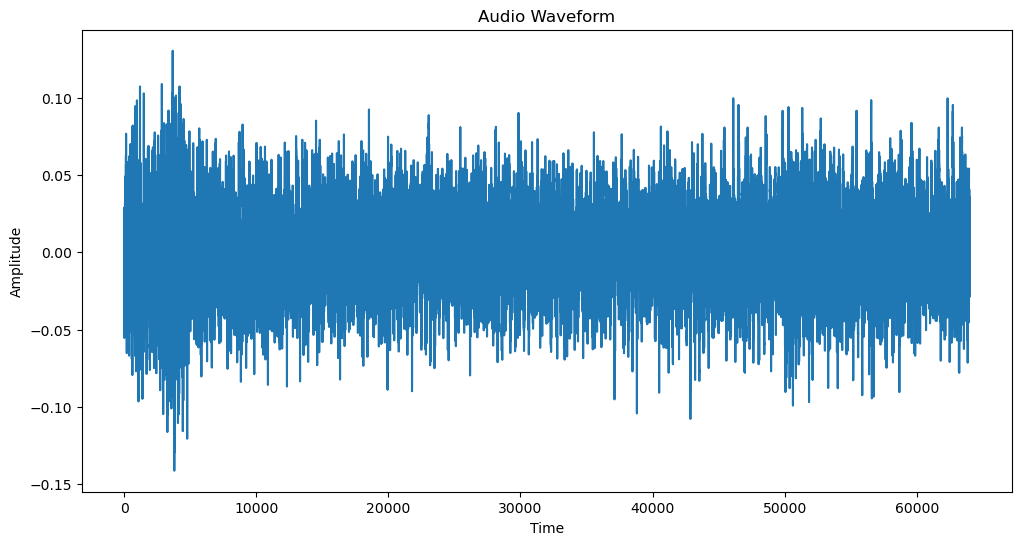

In [20]:
random_clips=audio_random_sampling_2(total_samples=5,audio_segment=slice_5_test[0])

print(random_clips)
print(len(random_clips))

audio_arrays_test=audio2array(random_clips)

print(audio_arrays_test)

print(audio_arrays_test[0])
print(type(audio_arrays_test[0]))




for i in audio_arrays_test:
    array_norm=audio_bitrate_norm(bit_rate=bit_rate_test,audio_array=i)

    plt.figure(figsize=(12, 6))
    plt.plot(array_norm)
    plt.title('Audio Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')   
    plt.show()


In [21]:
# Now that we have prepared the random audio components, we need to convert each audio from the time domain to the frequency domain.

def timeD2preqD(normalized_clip:np.array,sr:int):
    """
    transform audio from time domain to frequency domain

    Parameters:
        normalized_clip: the single clip in array format (data)
        sr: sampling rate

    Return:
        Due to symmetry, only half the spectrum is needed.
        And becuase the range of frequencies depends on the sampling rate of the audio signal.
        we do not need the frequency info, all of them are the same.
    """
    fft = np.fft.fft(normalized_clip)
    magnitude = np.abs(fft)
    frequency = np.linspace(0, sr, len(magnitude))

    half_len = len(magnitude) // 2 
    frequency=frequency[:half_len]
    magnitude=magnitude[:half_len]

    return magnitude,frequency


[array([ 0.0164568 ,  0.00626021,  0.00461538, ...,  0.00579518,
       -0.00409826, -0.01579343]), array([-0.0422712 , -0.03924156, -0.03795474, ...,  0.02742944,
        0.02504981,  0.02455318]), array([-0.00374246, -0.00355186,  0.0003077 , ..., -0.01237454,
       -0.03108839, -0.0624809 ]), array([ 0.02723349,  0.02447952,  0.02960951, ..., -0.0156255 ,
       -0.00828356, -0.00844992]), array([ 0.01494852,  0.02329851,  0.02895185, ..., -0.0013606 ,
       -0.01785846, -0.02854049])]
5
(5, 64000)


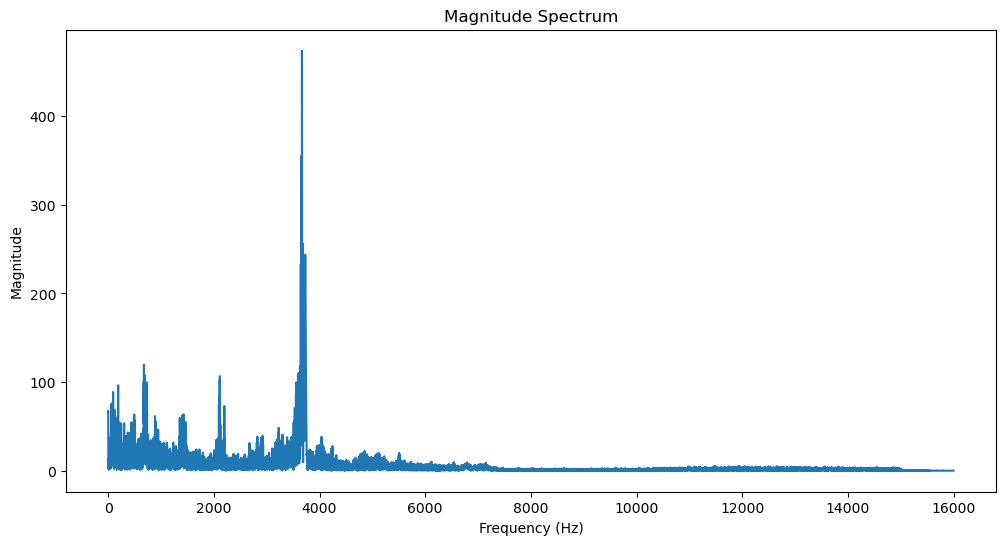

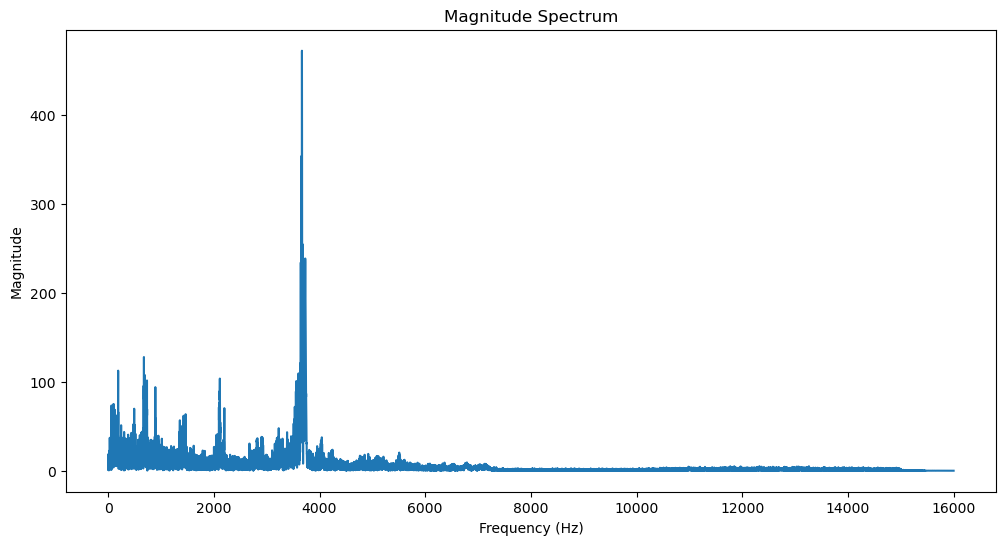

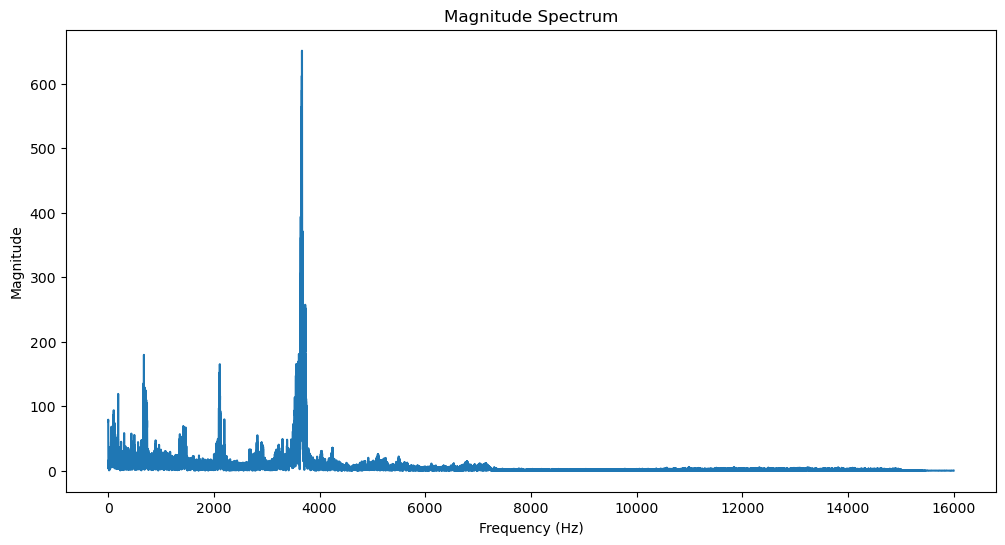

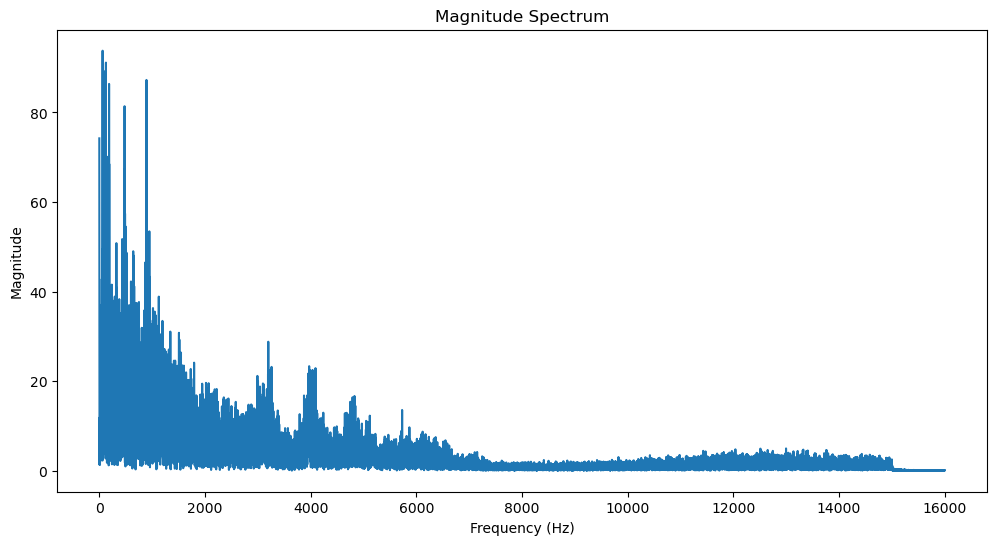

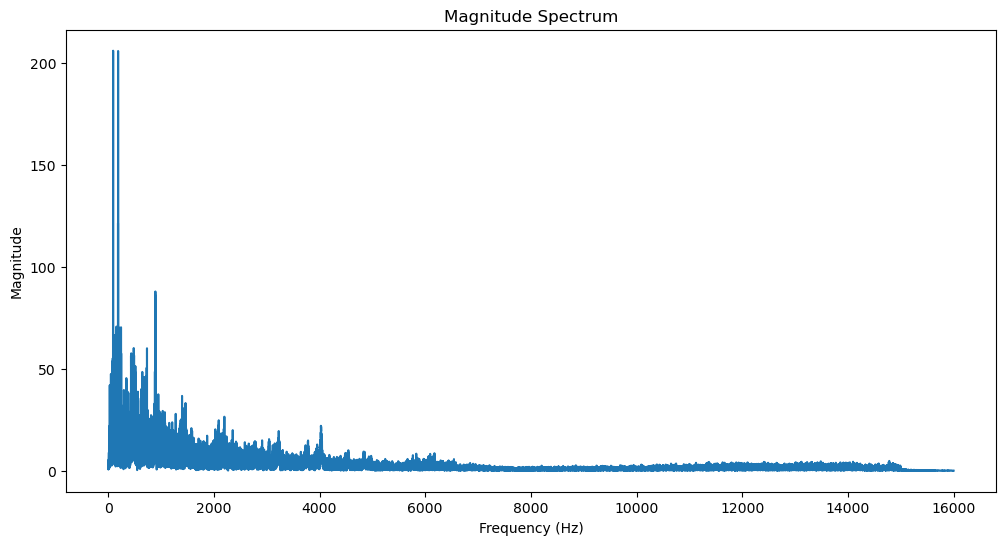

In [22]:
arrays_norm=[]
for i in audio_arrays_test:
    array_norm=audio_bitrate_norm(bit_rate=bit_rate_test,audio_array=i)
    arrays_norm.append(array_norm)

print(arrays_norm)

print(len(arrays_norm))

arrays_norm=np.array(arrays_norm)

print(arrays_norm.shape)


## If you want to run this step, add the frequency return in the timeD2preqD function

for i in arrays_norm:
    magnitude,frequency=timeD2preqD(normalized_clip=i,sr=sr_test)
    plt.figure(figsize=(12, 6))
    plt.plot(frequency, magnitude)
    plt.title('Magnitude Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')

## Next, we need to connect the whole process and prepare the label list at the same time

We expect the input to the chronoNet model (batch_size, channel_num, length)

In [23]:
# integrate all data paths together

parent_directory='../../data/train'

sub_folders=glob.glob(os.path.join(parent_directory,'*'))

files=[]

for folder_path in sub_folders:
    first_file=glob.glob(os.path.join(folder_path,'*.ogg'))
    files.extend(first_file)


In [24]:
print(files)
print(len(files))

['../../data/train/ashpri1/XC116339.ogg', '../../data/train/ashpri1/XC116338.ogg', '../../data/train/asikoe2/XC138196.ogg', '../../data/train/asikoe2/XC115086.ogg', '../../data/train/ashwoo2/XC169810.ogg', '../../data/train/ashwoo2/XC125152.ogg', '../../data/train/ashdro1/XC114599.ogg', '../../data/train/ashdro1/XC114598.ogg', '../../data/train/asiope1/XC194954.ogg', '../../data/train/asiope1/XC397761.ogg', '../../data/train/asbfly/XC134896.ogg', '../../data/train/asbfly/XC164848.ogg']
12


In [25]:
labels_list=[]
all_audios_magnitude=[]
for path in files:
    print(path)
    labels=[]
    # extract label
    label=path.split('/')[-2]

    # read audio
    audio=read_audio(path)

    # grab audio information
    duration_secconds,sr,num_channels,bit_rate=audio_info(audio)

    # slice audio into multi 5 seconds
    slice_5_all=slice_audio_5_align(audio)

    for single_slice in slice_5_all:

        # slice audio on each 5 sec long audio and generate multi 2 sec clips
        random_clips=audio_random_sampling_2(total_samples=5,audio_segment=single_slice)

        # convert all 2 sec clips to array format
        audio_arrays_2sec=audio2array(random_clips)

        # normalize each 2 sec audio array 
        arrays_2sec_norm=[]
        for i in audio_arrays_2sec:
            array_2sec_norm=audio_bitrate_norm(bit_rate=bit_rate,audio_array=i)
            arrays_2sec_norm.append(array_2sec_norm)
        
        arrays_2sec_norm=np.array(arrays_2sec_norm)

        # conver audio from time domain to frequency domain
        audios_magnitude=[]
        for i in arrays_2sec_norm:
            magnitude,frequency=timeD2preqD(normalized_clip=i,sr=sr)
            audios_magnitude.append(magnitude)

        # audios_magnitude=np.array(audios_magnitude)

        labels.append(label)
        all_audios_magnitude.append(audios_magnitude)


    # all_audios_magnitude=np.array(all_audios_magnitude)

    
    labels_list.append(labels)



../../data/train/ashpri1/XC116339.ogg
../../data/train/ashpri1/XC116338.ogg
../../data/train/asikoe2/XC138196.ogg
../../data/train/asikoe2/XC115086.ogg
../../data/train/ashwoo2/XC169810.ogg
../../data/train/ashwoo2/XC125152.ogg
../../data/train/ashdro1/XC114599.ogg
../../data/train/ashdro1/XC114598.ogg
../../data/train/asiope1/XC194954.ogg
../../data/train/asiope1/XC397761.ogg
../../data/train/asbfly/XC134896.ogg
../../data/train/asbfly/XC164848.ogg


In [26]:
print(labels_list)

[['ashpri1', 'ashpri1'], ['ashpri1', 'ashpri1', 'ashpri1', 'ashpri1', 'ashpri1', 'ashpri1'], ['asikoe2', 'asikoe2', 'asikoe2', 'asikoe2', 'asikoe2'], ['asikoe2', 'asikoe2', 'asikoe2', 'asikoe2', 'asikoe2'], ['ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2'], ['ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2'], ['ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1'], ['ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1'], ['asiope1', 'asiope1', 'asiope1'], ['asiope1'], ['asbfly', 'asbfly', 'asbfly', 'asbfly', 'asbfly', 'asbfly'], ['asbfly', 'asbfly', 'asbfly', 'asbfly']]


In [33]:
flattened_list = [element for sublist in labels_list for element in sublist]
print(flattened_list)
print(len(flattened_list))

['ashpri1', 'ashpri1', 'ashpri1', 'ashpri1', 'ashpri1', 'ashpri1', 'ashpri1', 'ashpri1', 'asikoe2', 'asikoe2', 'asikoe2', 'asikoe2', 'asikoe2', 'asikoe2', 'asikoe2', 'asikoe2', 'asikoe2', 'asikoe2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashwoo2', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'ashdro1', 'asiope1', 'asiope1', 'asiope1', 'asiope1', 'asbfly', 'asbfly', 'asbfly', 'asbfly', 'asbfly', 'asbfly', 'asbfly', 'asbfly', 'asbfly', 'asbfly']
67


In [29]:
print(np.array(all_audios_magnitude))

[[[4.57271779e+00 7.41447548e-01 5.09866299e+00 ... 1.33175993e-01
   1.31418237e-01 1.57717741e-01]
  [3.19600417e+00 6.97707329e+00 2.62919728e+00 ... 1.21981111e-01
   1.17849560e-01 1.15295303e-01]
  [5.44961239e+00 5.30570040e-01 7.49716160e-01 ... 3.85371623e-02
   3.40351946e-02 6.36409395e-02]
  [1.42447326e+01 9.41829670e+00 5.87239240e+00 ... 5.17463180e-02
   4.51454622e-02 3.54770712e-02]
  [1.81747500e+01 1.31592876e+01 8.29403054e+00 ... 2.41468827e-02
   3.84349469e-02 3.45559143e-02]]

 [[1.71874927e-01 7.66699966e-01 1.40811122e+00 ... 6.31599538e-02
   5.67950116e-02 6.30700443e-02]
  [4.83216655e+00 2.21066605e+00 3.39835416e+00 ... 1.67825260e-01
   1.84404116e-01 1.39695300e-01]
  [2.02571673e+00 3.32519821e+00 3.43308770e+00 ... 1.10313225e-01
   1.03442758e-01 1.11017057e-01]
  [3.50371688e+00 1.33265285e+00 2.26967674e-01 ... 3.80193529e-02
   4.76782438e-02 6.48704468e-02]
  [1.30031695e+00 5.12152604e+00 4.01525190e+00 ... 3.77410728e-02
   6.65244897e-02 8.70

In [31]:
print(np.array(all_audios_magnitude).shape)

(67, 5, 32000)
